In [2]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# import torch

# class RAFDBDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
#         self.labels = pd.read_csv(csv_file)
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
#         image = Image.open(img_name)
#         label = self.labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [3]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
                            img_dir='archive/RAF-DB/train/',
                            transform=transform)

# rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/FER2013/train_FER_labels.csv',
#                             img_dir='archive/FER2013/train/',
#                             transform=transform)

# rafdb_dataset_train = GiMeFiveDataset(csv_file='data/train_labels.csv',
#                             img_dir='data/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='data/valid_labels.csv',
                            img_dir='data/valid',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
                            img_dir='archive/RAF-DB/test/',
                            transform=transform)

# rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/FER2013/test_FER_labels.csv',
#                             img_dir='archive/FER2013/test/',
#                             transform=transform)

# rafdb_dataset_test = GiMeFiveDataset(csv_file='data/test_labels.csv',
#                             img_dir='data/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [4]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [6]:

# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)
#         self.res_block5 = ResidualBlock(1024, 2048, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(2048, 4096)
#         self.fc2 = nn.Linear(4096, 2048) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(2048, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
#         x = self.res_block5(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [7]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)

    def forward(self, x): # (batch_size, channels=3, 64, 64)
        x = F.relu(self.bn1(self.conv1(x))) # (batch_size, 64, 64, 64)
        x = F.max_pool2d(x, 2) # (batch_size, 64, 32, 32)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x))) # (batch_size, 128, 32, 32)
        x = F.max_pool2d(x, 2) # (batch_size, 128, 16, 16)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x))) # (batch_size, 256, 16, 16)
        x = F.max_pool2d(x, 2) # (batch_size, 256, 8, 8)
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.conv4(x))) # (batch_size, 512, 8, 8)
        x = F.max_pool2d(x, 2) # (batch_size, 512, 4, 4)
        x = self.dropout1(x)
        x = F.relu(self.bn5(self.conv5(x))) # (batch_size, 1024, 4, 4)
        x = F.max_pool2d(x, 2) # (batch_size, 1024, 2, 2)
        # x = self.dropout1(x)
        
        x = self.pool(x) # (batch_size, 1024, 1, 1)
        x = x.view(x.size(0), -1) # (batch_size, 1024) # Flatten
        x = F.relu(self.fc1(x)) # (batch_size, 2048)
        x = self.dropout2(x) # (batch_size, 2048)
        x = F.relu(self.fc2(x)) # (batch_size, 1024)
        x = self.fc3(x) # (batch_size, 6)
        return x

model = EmotionClassifier().to(device)

In [8]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [10]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        # self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        # self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 512) 
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = F.max_pool2d(x, 2) 
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2) 
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.conv4(x))) 
        x = F.max_pool2d(x, 2) 
        x = self.dropout1(x)
        # x = F.relu(self.bn5(self.conv5(x))) 
        # x = F.max_pool2d(x, 2)
        # x = self.dropout1(x)
        
        x = self.pool(x) 
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = self.dropout2(x) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x
    
model = Baseline().to(device)

In [11]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 2606086


In [10]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [11]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [12]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [13]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


patience = 15
best_val_acc = 0  
patience_counter = 0

num_epochs = 80

In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/80: 100%|██████████| 610/610 [00:45<00:00, 13.27it/s]


Epoch 1, Train Loss: 1.3765998897982425, Train Accuracy: 0.4935358095628976, Test Loss: 1.4543855595588684, Test Accuracy: 0.49727691663175533, Validation Loss: 2.4610698630935266, Validation Accuracy: 0.1686143572621035


Epoch 2/80: 100%|██████████| 610/610 [00:45<00:00, 13.42it/s]


Epoch 2, Train Loss: 1.2574041151609576, Train Accuracy: 0.5358095628975991, Test Loss: 1.4450261031587919, Test Accuracy: 0.5245077503142019, Validation Loss: 2.560710078791568, Validation Accuracy: 0.21035058430717862


Epoch 3/80: 100%|██████████| 610/610 [00:45<00:00, 13.40it/s]


Epoch 3, Train Loss: 1.1133446943564493, Train Accuracy: 0.5892673917504617, Test Loss: 1.0622586748997371, Test Accuracy: 0.6154168412232929, Validation Loss: 1.9728685993897288, Validation Accuracy: 0.31385642737896496


Epoch 4/80: 100%|██████████| 610/610 [00:45<00:00, 13.33it/s]


Epoch 4, Train Loss: 0.9990400203427331, Train Accuracy: 0.6402626718653807, Test Loss: 0.9659165557225545, Test Accuracy: 0.6539589442815249, Validation Loss: 1.673867382501301, Validation Accuracy: 0.39065108514190316


Epoch 5/80: 100%|██████████| 610/610 [00:45<00:00, 13.33it/s]


Epoch 5, Train Loss: 0.9043094027726377, Train Accuracy: 0.6778165401190231, Test Loss: 0.8847861917379002, Test Accuracy: 0.6983661499790532, Validation Loss: 1.7760477191523503, Validation Accuracy: 0.41736227045075125


Epoch 6/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 6, Train Loss: 0.8238150859465364, Train Accuracy: 0.7078801559614201, Test Loss: 0.7840002653747797, Test Accuracy: 0.7381650607457059, Validation Loss: 1.42940554493352, Validation Accuracy: 0.49248747913188645


Epoch 7/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 7, Train Loss: 0.7779673532872904, Train Accuracy: 0.719577262466653, Test Loss: 0.7157164648175239, Test Accuracy: 0.754084625052367, Validation Loss: 1.454172217532208, Validation Accuracy: 0.4991652754590985


Epoch 8/80: 100%|██████████| 610/610 [00:45<00:00, 13.28it/s]


Epoch 8, Train Loss: 0.736006154413106, Train Accuracy: 0.7358916478555305, Test Loss: 0.7873710527239989, Test Accuracy: 0.7385839966485128, Validation Loss: 1.5427075404869883, Validation Accuracy: 0.48580968280467446
No improvement in validation accuracy for 1 epochs.


Epoch 9/80: 100%|██████████| 610/610 [00:45<00:00, 13.42it/s]


Epoch 9, Train Loss: 0.6953895998782799, Train Accuracy: 0.751282577467679, Test Loss: 0.6540453974592189, Test Accuracy: 0.7779639715123586, Validation Loss: 1.387228388535349, Validation Accuracy: 0.5308848080133556


Epoch 10/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 10, Train Loss: 0.6657527811214572, Train Accuracy: 0.7622614405910118, Test Loss: 0.604961874447763, Test Accuracy: 0.7972350230414746, Validation Loss: 1.1944092402332707, Validation Accuracy: 0.5843071786310517


Epoch 11/80: 100%|██████████| 610/610 [00:45<00:00, 13.29it/s]


Epoch 11, Train Loss: 0.6306585620661251, Train Accuracy: 0.7775497640057459, Test Loss: 0.6083984733993808, Test Accuracy: 0.7984918307498953, Validation Loss: 1.1976830708353143, Validation Accuracy: 0.5859766277128547


Epoch 12/80: 100%|██████████| 610/610 [00:46<00:00, 13.21it/s]


Epoch 12, Train Loss: 0.6145916915086449, Train Accuracy: 0.7811409809152473, Test Loss: 0.5952112052962184, Test Accuracy: 0.7984918307498953, Validation Loss: 1.1679706777396954, Validation Accuracy: 0.5926544240400667


Epoch 13/80: 100%|██████████| 610/610 [00:45<00:00, 13.39it/s]


Epoch 13, Train Loss: 0.5893693524183797, Train Accuracy: 0.7909911758670224, Test Loss: 0.5565078528039158, Test Accuracy: 0.8152492668621701, Validation Loss: 1.1436472597875094, Validation Accuracy: 0.6243739565943238


Epoch 14/80: 100%|██████████| 610/610 [00:45<00:00, 13.27it/s]


Epoch 14, Train Loss: 0.5801352381217675, Train Accuracy: 0.8000205212394829, Test Loss: 0.5638876891260346, Test Accuracy: 0.8139924591537495, Validation Loss: 1.1668302808937274, Validation Accuracy: 0.6293823038397329


Epoch 15/80: 100%|██████████| 610/610 [00:45<00:00, 13.35it/s]


Epoch 15, Train Loss: 0.5526844626078841, Train Accuracy: 0.8016622203981121, Test Loss: 0.5436410147572557, Test Accuracy: 0.8165060745705907, Validation Loss: 1.0892476706128371, Validation Accuracy: 0.6460767946577629


Epoch 16/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 16, Train Loss: 0.5365704442817169, Train Accuracy: 0.8124358711266161, Test Loss: 0.5530681245184194, Test Accuracy: 0.8173439463762044, Validation Loss: 1.1329340809269954, Validation Accuracy: 0.6377295492487479
No improvement in validation accuracy for 1 epochs.


Epoch 17/80: 100%|██████████| 610/610 [00:45<00:00, 13.40it/s]


Epoch 17, Train Loss: 0.5233084035335017, Train Accuracy: 0.8144879950749025, Test Loss: 0.5419179718755186, Test Accuracy: 0.8139924591537495, Validation Loss: 0.9952216775793779, Validation Accuracy: 0.664440734557596


Epoch 18/80: 100%|██████████| 610/610 [00:45<00:00, 13.39it/s]


Epoch 18, Train Loss: 0.5119163614438206, Train Accuracy: 0.8160270880361173, Test Loss: 0.5252177409331004, Test Accuracy: 0.8177628822790113, Validation Loss: 0.8577406288761842, Validation Accuracy: 0.6811352253756261


Epoch 19/80: 100%|██████████| 610/610 [00:45<00:00, 13.31it/s]


Epoch 19, Train Loss: 0.48309401079523756, Train Accuracy: 0.8309049866611944, Test Loss: 0.5597567103865246, Test Accuracy: 0.8123167155425219, Validation Loss: 1.1058103755900734, Validation Accuracy: 0.6377295492487479
No improvement in validation accuracy for 1 epochs.


Epoch 20/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 20, Train Loss: 0.4761941325224814, Train Accuracy: 0.8328545044120665, Test Loss: 0.4948379107067982, Test Accuracy: 0.8353581901968998, Validation Loss: 0.9339871147745534, Validation Accuracy: 0.6978297161936561


Epoch 21/80: 100%|██████████| 610/610 [00:45<00:00, 13.35it/s]


Epoch 21, Train Loss: 0.46733423713900024, Train Accuracy: 0.8341883849784527, Test Loss: 0.5241363753005862, Test Accuracy: 0.8232090490155006, Validation Loss: 1.0195943281838769, Validation Accuracy: 0.669449081803005
No improvement in validation accuracy for 1 epochs.


Epoch 22/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 22, Train Loss: 0.44248735395977734, Train Accuracy: 0.8420890621793556, Test Loss: 0.5768257623142563, Test Accuracy: 0.8165060745705907, Validation Loss: 1.1321393306318082, Validation Accuracy: 0.657762938230384
No improvement in validation accuracy for 2 epochs.


Epoch 23/80: 100%|██████████| 610/610 [00:45<00:00, 13.38it/s]


Epoch 23, Train Loss: 0.432204544727431, Train Accuracy: 0.8461933100759286, Test Loss: 0.5434299280991157, Test Accuracy: 0.8257226644323419, Validation Loss: 1.0791316612770683, Validation Accuracy: 0.657762938230384
No improvement in validation accuracy for 3 epochs.


Epoch 24/80: 100%|██████████| 610/610 [00:45<00:00, 13.38it/s]


Epoch 24, Train Loss: 0.4198956777082115, Train Accuracy: 0.8517340447363021, Test Loss: 0.5210027886430423, Test Accuracy: 0.8186007540846251, Validation Loss: 0.9366604811266849, Validation Accuracy: 0.6894824707846411
No improvement in validation accuracy for 4 epochs.


Epoch 25/80: 100%|██████████| 610/610 [00:46<00:00, 13.24it/s]


Epoch 25, Train Loss: 0.41074026437690025, Train Accuracy: 0.8570695670018469, Test Loss: 0.5766532888108243, Test Accuracy: 0.8102220360284876, Validation Loss: 1.0160825879950273, Validation Accuracy: 0.6811352253756261
No improvement in validation accuracy for 5 epochs.


Epoch 26/80: 100%|██████████| 610/610 [00:45<00:00, 13.45it/s]


Epoch 26, Train Loss: 0.39635026017661956, Train Accuracy: 0.8609686025035912, Test Loss: 0.4945898161145548, Test Accuracy: 0.8408043569333892, Validation Loss: 0.9274849326987016, Validation Accuracy: 0.7078464106844741


Epoch 27/80: 100%|██████████| 610/610 [00:46<00:00, 13.23it/s]


Epoch 27, Train Loss: 0.38264932750922737, Train Accuracy: 0.8617894520829058, Test Loss: 0.5596740935308238, Test Accuracy: 0.8190196899874319, Validation Loss: 1.0062892672262693, Validation Accuracy: 0.664440734557596
No improvement in validation accuracy for 1 epochs.


Epoch 28/80: 100%|██████████| 610/610 [00:46<00:00, 13.14it/s]


Epoch 28, Train Loss: 0.3645916356338707, Train Accuracy: 0.8728709214036527, Test Loss: 0.5110540566143269, Test Accuracy: 0.8378718056137411, Validation Loss: 0.9855044295913294, Validation Accuracy: 0.7078464106844741
No improvement in validation accuracy for 2 epochs.


Epoch 29/80: 100%|██████████| 610/610 [00:46<00:00, 13.13it/s]


Epoch 29, Train Loss: 0.36685146566663607, Train Accuracy: 0.871331828442438, Test Loss: 0.4694682212856909, Test Accuracy: 0.8496020108923334, Validation Loss: 0.9849302305987007, Validation Accuracy: 0.6878130217028381
No improvement in validation accuracy for 3 epochs.


Epoch 30/80: 100%|██████████| 610/610 [00:46<00:00, 13.26it/s]


Epoch 30, Train Loss: 0.35159545852268326, Train Accuracy: 0.8778986250769546, Test Loss: 0.5113984572130721, Test Accuracy: 0.8466694595726854, Validation Loss: 1.0402857959270477, Validation Accuracy: 0.679465776293823
No improvement in validation accuracy for 4 epochs.


Epoch 31/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 31, Train Loss: 0.34591530482284727, Train Accuracy: 0.878001231274369, Test Loss: 0.5014795144585271, Test Accuracy: 0.8303309593632174, Validation Loss: 0.885557238600756, Validation Accuracy: 0.7228714524207012


Epoch 32/80: 100%|██████████| 610/610 [00:46<00:00, 13.16it/s]


Epoch 32, Train Loss: 0.3259031200689859, Train Accuracy: 0.8847732403037143, Test Loss: 0.5272079390574557, Test Accuracy: 0.8449937159614579, Validation Loss: 1.0899028981986798, Validation Accuracy: 0.6928213689482471
No improvement in validation accuracy for 1 epochs.


Epoch 33/80: 100%|██████████| 610/610 [00:46<00:00, 13.13it/s]


Epoch 33, Train Loss: 0.32131375635546616, Train Accuracy: 0.8894931253847732, Test Loss: 0.5139191147731617, Test Accuracy: 0.834939254294093, Validation Loss: 1.0268658172143132, Validation Accuracy: 0.6911519198664441
No improvement in validation accuracy for 2 epochs.


Epoch 34/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 34, Train Loss: 0.3203990333820464, Train Accuracy: 0.8854914836856146, Test Loss: 0.4875431373684357, Test Accuracy: 0.8496020108923334, Validation Loss: 0.9657508452471933, Validation Accuracy: 0.7161936560934892
No improvement in validation accuracy for 3 epochs.


Epoch 35/80: 100%|██████████| 610/610 [00:45<00:00, 13.32it/s]


Epoch 35, Train Loss: 0.296403803624457, Train Accuracy: 0.895752103427047, Test Loss: 0.619582176967524, Test Accuracy: 0.8232090490155006, Validation Loss: 1.1567828184679936, Validation Accuracy: 0.6811352253756261
No improvement in validation accuracy for 4 epochs.


Epoch 36/80: 100%|██████████| 610/610 [00:45<00:00, 13.32it/s]


Epoch 36, Train Loss: 0.29784522481934456, Train Accuracy: 0.8947260414529038, Test Loss: 0.5148653349280358, Test Accuracy: 0.8378718056137411, Validation Loss: 0.956295393015209, Validation Accuracy: 0.7078464106844741
No improvement in validation accuracy for 5 epochs.


Epoch 37/80: 100%|██████████| 610/610 [00:45<00:00, 13.32it/s]


Epoch 37, Train Loss: 0.2870287560323467, Train Accuracy: 0.8994459265339626, Test Loss: 0.5462641606184965, Test Accuracy: 0.8307498952660243, Validation Loss: 0.9772712443219987, Validation Accuracy: 0.7028380634390651
No improvement in validation accuracy for 6 epochs.


Epoch 38/80: 100%|██████████| 610/610 [00:45<00:00, 13.33it/s]


Epoch 38, Train Loss: 0.2727084962490824, Train Accuracy: 0.9017032628770778, Test Loss: 0.5119344728284826, Test Accuracy: 0.8508588186007541, Validation Loss: 1.1206358302580683, Validation Accuracy: 0.6944908180300501
No improvement in validation accuracy for 7 epochs.


Epoch 39/80: 100%|██████████| 610/610 [00:45<00:00, 13.38it/s]


Epoch 39, Train Loss: 0.26809308937766024, Train Accuracy: 0.9045762364046789, Test Loss: 0.5489195190335159, Test Accuracy: 0.8307498952660243, Validation Loss: 1.0201959562929053, Validation Accuracy: 0.7045075125208681
No improvement in validation accuracy for 8 epochs.


Epoch 40/80: 100%|██████████| 610/610 [00:45<00:00, 13.39it/s]


Epoch 40, Train Loss: 0.26357670125597327, Train Accuracy: 0.9052944797865791, Test Loss: 0.5650943707674742, Test Accuracy: 0.8265605362379556, Validation Loss: 0.9651609972903603, Validation Accuracy: 0.7278797996661102


Epoch 41/80: 100%|██████████| 610/610 [00:45<00:00, 13.35it/s]


Epoch 41, Train Loss: 0.2566056968430515, Train Accuracy: 0.9058075107736507, Test Loss: 0.5200274051850041, Test Accuracy: 0.8441558441558441, Validation Loss: 0.9834040654333014, Validation Accuracy: 0.7212020033388982
No improvement in validation accuracy for 1 epochs.


Epoch 42/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 42, Train Loss: 0.23657779466269202, Train Accuracy: 0.9162733429099118, Test Loss: 0.4953618416485066, Test Accuracy: 0.8563049853372434, Validation Loss: 0.9675407174386477, Validation Accuracy: 0.7278797996661102
No improvement in validation accuracy for 2 epochs.


Epoch 43/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 43, Train Loss: 0.23431018091848915, Train Accuracy: 0.9178124358711266, Test Loss: 0.507431059764543, Test Accuracy: 0.8537913699204022, Validation Loss: 1.0312070658332424, Validation Accuracy: 0.7262103505843072
No improvement in validation accuracy for 3 epochs.


Epoch 44/80: 100%|██████████| 610/610 [00:46<00:00, 13.23it/s]


Epoch 44, Train Loss: 0.23520663786129872, Train Accuracy: 0.9152472809357686, Test Loss: 0.5142096840823069, Test Accuracy: 0.8525345622119815, Validation Loss: 1.0513745648296255, Validation Accuracy: 0.7195325542570952
No improvement in validation accuracy for 4 epochs.


Epoch 45/80: 100%|██████████| 610/610 [00:45<00:00, 13.35it/s]


Epoch 45, Train Loss: 0.21699554405068278, Train Accuracy: 0.9261235378616869, Test Loss: 0.556557598868385, Test Accuracy: 0.8353581901968998, Validation Loss: 0.927517927790943, Validation Accuracy: 0.7328881469115192


Epoch 46/80: 100%|██████████| 610/610 [00:45<00:00, 13.40it/s]


Epoch 46, Train Loss: 0.21781398037975258, Train Accuracy: 0.9221218961625283, Test Loss: 0.5490251500729937, Test Accuracy: 0.8491830749895266, Validation Loss: 1.0245565987731282, Validation Accuracy: 0.7245409015025042
No improvement in validation accuracy for 1 epochs.


Epoch 47/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 47, Train Loss: 0.2169915274480266, Train Accuracy: 0.9254052944797866, Test Loss: 0.5035767838327835, Test Accuracy: 0.8437369082530373, Validation Loss: 0.83443964508019, Validation Accuracy: 0.7495826377295493


Epoch 48/80: 100%|██████████| 610/610 [00:45<00:00, 13.42it/s]


Epoch 48, Train Loss: 0.20989898931097667, Train Accuracy: 0.9235583829263287, Test Loss: 0.5543197862710804, Test Accuracy: 0.847926267281106, Validation Loss: 1.1458379155711125, Validation Accuracy: 0.6911519198664441
No improvement in validation accuracy for 1 epochs.


Epoch 49/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 49, Train Loss: 0.20247466763534935, Train Accuracy: 0.924584444900472, Test Loss: 0.6576272147161459, Test Accuracy: 0.8399664851277755, Validation Loss: 1.409368304045577, Validation Accuracy: 0.672787979966611
No improvement in validation accuracy for 2 epochs.


Epoch 50/80: 100%|██████████| 610/610 [00:45<00:00, 13.38it/s]


Epoch 50, Train Loss: 0.19536358284893765, Train Accuracy: 0.9285860865996306, Test Loss: 0.5283034879535747, Test Accuracy: 0.8533724340175953, Validation Loss: 1.0076876149365777, Validation Accuracy: 0.7362270450751253
No improvement in validation accuracy for 3 epochs.


Epoch 51/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 51, Train Loss: 0.1967210039675816, Train Accuracy: 0.9295095423763595, Test Loss: 0.5454278037374994, Test Accuracy: 0.8504398826979472, Validation Loss: 1.14254755722849, Validation Accuracy: 0.7111853088480802
No improvement in validation accuracy for 4 epochs.


Epoch 52/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 52, Train Loss: 0.18563506075135264, Train Accuracy: 0.9336137902729325, Test Loss: 0.5168787108361721, Test Accuracy: 0.857561793045664, Validation Loss: 1.0812015251109475, Validation Accuracy: 0.7328881469115192
No improvement in validation accuracy for 5 epochs.


Epoch 53/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 53, Train Loss: 0.17347986082370837, Train Accuracy: 0.9367945823927766, Test Loss: 0.5415396006102674, Test Accuracy: 0.8491830749895266, Validation Loss: 0.9734834546321317, Validation Accuracy: 0.7445742904841403
No improvement in validation accuracy for 6 epochs.


Epoch 54/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 54, Train Loss: 0.1658790378644299, Train Accuracy: 0.9419248922634927, Test Loss: 0.5818256710311592, Test Accuracy: 0.8558860494344366, Validation Loss: 1.2515766353983628, Validation Accuracy: 0.7212020033388982
No improvement in validation accuracy for 7 epochs.


Epoch 55/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 55, Train Loss: 0.17346031408123366, Train Accuracy: 0.9369997947876052, Test Loss: 0.5526712929610706, Test Accuracy: 0.8496020108923334, Validation Loss: 1.1346867907988398, Validation Accuracy: 0.7111853088480802
No improvement in validation accuracy for 8 epochs.


Epoch 56/80: 100%|██████████| 610/610 [00:45<00:00, 13.33it/s]


Epoch 56, Train Loss: 0.16055359634662383, Train Accuracy: 0.9441822286066078, Test Loss: 0.5527689851166118, Test Accuracy: 0.8600754084625052, Validation Loss: 1.0230263248085976, Validation Accuracy: 0.7495826377295493
No improvement in validation accuracy for 9 epochs.


Epoch 57/80: 100%|██████████| 610/610 [00:45<00:00, 13.41it/s]


Epoch 57, Train Loss: 0.15603815900330284, Train Accuracy: 0.9438744100143649, Test Loss: 0.5701464145826078, Test Accuracy: 0.8596564725596983, Validation Loss: 1.180044193801127, Validation Accuracy: 0.7362270450751253
No improvement in validation accuracy for 10 epochs.


Epoch 58/80: 100%|██████████| 610/610 [00:45<00:00, 13.47it/s]


Epoch 58, Train Loss: 0.15455408454102132, Train Accuracy: 0.9456187153704084, Test Loss: 0.6093896305275848, Test Accuracy: 0.8571428571428571, Validation Loss: 1.245890081713074, Validation Accuracy: 0.7228714524207012
No improvement in validation accuracy for 11 epochs.


Epoch 59/80: 100%|██████████| 610/610 [00:45<00:00, 13.42it/s]


Epoch 59, Train Loss: 0.15060112932773276, Train Accuracy: 0.9456187153704084, Test Loss: 0.6170810931319526, Test Accuracy: 0.8403854210305823, Validation Loss: 1.1686939526545375, Validation Accuracy: 0.7262103505843072
No improvement in validation accuracy for 12 epochs.


Epoch 60/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 60, Train Loss: 0.13999895192930842, Train Accuracy: 0.949312538477324, Test Loss: 0.6144475544504046, Test Accuracy: 0.8491830749895266, Validation Loss: 1.2907191985531856, Validation Accuracy: 0.7111853088480802
No improvement in validation accuracy for 13 epochs.


Epoch 61/80: 100%|██████████| 610/610 [00:45<00:00, 13.38it/s]


Epoch 61, Train Loss: 0.14730431832121227, Train Accuracy: 0.94613174635748, Test Loss: 0.5325883601373061, Test Accuracy: 0.8588186007540847, Validation Loss: 1.0042492739464108, Validation Accuracy: 0.7579298831385642


Epoch 62/80: 100%|██████████| 610/610 [00:45<00:00, 13.37it/s]


Epoch 62, Train Loss: 0.13825895629539803, Train Accuracy: 0.9513646624256105, Test Loss: 0.5759722454073684, Test Accuracy: 0.8558860494344366, Validation Loss: 1.1627761364767426, Validation Accuracy: 0.7262103505843072
No improvement in validation accuracy for 1 epochs.


Epoch 63/80: 100%|██████████| 610/610 [00:45<00:00, 13.35it/s]


Epoch 63, Train Loss: 0.1315031280712469, Train Accuracy: 0.9538272111635543, Test Loss: 0.614875148505865, Test Accuracy: 0.8563049853372434, Validation Loss: 1.2947207869667756, Validation Accuracy: 0.7245409015025042
No improvement in validation accuracy for 2 epochs.


Epoch 64/80: 100%|██████████| 610/610 [00:45<00:00, 13.36it/s]


Epoch 64, Train Loss: 0.1289420125996465, Train Accuracy: 0.953108967781654, Test Loss: 0.6388315195590257, Test Accuracy: 0.8449937159614579, Validation Loss: 1.164969843469168, Validation Accuracy: 0.7445742904841403
No improvement in validation accuracy for 3 epochs.


Epoch 65/80: 100%|██████████| 610/610 [00:45<00:00, 13.35it/s]


Epoch 65, Train Loss: 0.12841868430555448, Train Accuracy: 0.9553663041247691, Test Loss: 0.596182693100612, Test Accuracy: 0.8529534981147885, Validation Loss: 1.1584805846214294, Validation Accuracy: 0.7462437395659433
No improvement in validation accuracy for 4 epochs.


Epoch 66/80: 100%|██████████| 610/610 [00:46<00:00, 13.24it/s]


Epoch 66, Train Loss: 0.12344416192258886, Train Accuracy: 0.9551610917299405, Test Loss: 0.6685332367747227, Test Accuracy: 0.854210305823209, Validation Loss: 1.4071627761188306, Validation Accuracy: 0.7111853088480802
No improvement in validation accuracy for 5 epochs.


Epoch 67/80: 100%|██████████| 610/610 [00:45<00:00, 13.31it/s]


Epoch 67, Train Loss: 0.11456227014654748, Train Accuracy: 0.9605992201928997, Test Loss: 0.5763119649792012, Test Accuracy: 0.8563049853372434, Validation Loss: 1.0095685351836055, Validation Accuracy: 0.7729549248747913


Epoch 68/80: 100%|██████████| 610/610 [00:45<00:00, 13.32it/s]


Epoch 68, Train Loss: 0.11861559466733673, Train Accuracy: 0.9577262466652986, Test Loss: 0.5596412339866704, Test Accuracy: 0.8638458315877671, Validation Loss: 1.0604514761974937, Validation Accuracy: 0.7679465776293823
No improvement in validation accuracy for 1 epochs.


Epoch 69/80: 100%|██████████| 610/610 [00:45<00:00, 13.34it/s]


Epoch 69, Train Loss: 0.11560336288801401, Train Accuracy: 0.9574184280730557, Test Loss: 0.5689473758762081, Test Accuracy: 0.8617511520737328, Validation Loss: 1.1225917284425937, Validation Accuracy: 0.7545909849749582
No improvement in validation accuracy for 2 epochs.


Epoch 70/80: 100%|██████████| 610/610 [00:45<00:00, 13.31it/s]


Epoch 70, Train Loss: 0.10266438643705696, Train Accuracy: 0.9637800123127437, Test Loss: 0.6783089286111257, Test Accuracy: 0.8537913699204022, Validation Loss: 1.441120938250893, Validation Accuracy: 0.7145242070116862
No improvement in validation accuracy for 3 epochs.


Epoch 71/80: 100%|██████████| 610/610 [00:45<00:00, 13.26it/s]


Epoch 71, Train Loss: 0.10505255572240205, Train Accuracy: 0.9641904371024009, Test Loss: 0.5827992253970782, Test Accuracy: 0.8638458315877671, Validation Loss: 1.0996013522932404, Validation Accuracy: 0.7445742904841403
No improvement in validation accuracy for 4 epochs.


Epoch 72/80: 100%|██████████| 610/610 [00:46<00:00, 13.26it/s]


Epoch 72, Train Loss: 0.10375708398365294, Train Accuracy: 0.9639852247075723, Test Loss: 0.5711681207648508, Test Accuracy: 0.8646837033933809, Validation Loss: 1.2030316489307504, Validation Accuracy: 0.7579298831385642
No improvement in validation accuracy for 5 epochs.


Epoch 73/80: 100%|██████████| 610/610 [00:45<00:00, 13.30it/s]


Epoch 73, Train Loss: 0.0997973572113074, Train Accuracy: 0.9636774061153294, Test Loss: 0.6000052911206148, Test Accuracy: 0.8625890238793464, Validation Loss: 1.0698488818383531, Validation Accuracy: 0.7662771285475793
No improvement in validation accuracy for 6 epochs.


Epoch 74/80: 100%|██████████| 610/610 [00:45<00:00, 13.28it/s]


Epoch 74, Train Loss: 0.09940897352043081, Train Accuracy: 0.9659347424584445, Test Loss: 0.7065069831572812, Test Accuracy: 0.841223292836196, Validation Loss: 1.3967211332760359, Validation Accuracy: 0.7061769616026711
No improvement in validation accuracy for 7 epochs.


Epoch 75/80: 100%|██████████| 610/610 [00:46<00:00, 13.23it/s]


Epoch 75, Train Loss: 0.1008809890009541, Train Accuracy: 0.9649086804843012, Test Loss: 0.6714028774016576, Test Accuracy: 0.8428990364474236, Validation Loss: 1.2139574301085974, Validation Accuracy: 0.7512520868113522
No improvement in validation accuracy for 8 epochs.


Epoch 76/80: 100%|██████████| 610/610 [00:45<00:00, 13.31it/s]


Epoch 76, Train Loss: 0.10340349390705833, Train Accuracy: 0.9625487379437718, Test Loss: 0.6111635814284091, Test Accuracy: 0.8638458315877671, Validation Loss: 1.2573265815643888, Validation Accuracy: 0.7495826377295493
No improvement in validation accuracy for 9 epochs.


Epoch 77/80: 100%|██████████| 610/610 [00:45<00:00, 13.30it/s]


Epoch 77, Train Loss: 0.10671966547556995, Train Accuracy: 0.9619331007592858, Test Loss: 0.631516252256503, Test Accuracy: 0.8604943443653121, Validation Loss: 1.3271358491558778, Validation Accuracy: 0.7245409015025042
No improvement in validation accuracy for 10 epochs.


Epoch 78/80: 100%|██████████| 610/610 [00:45<00:00, 13.31it/s]


Epoch 78, Train Loss: 0.08739613418683952, Train Accuracy: 0.968294684998974, Test Loss: 0.5798055074039439, Test Accuracy: 0.8651026392961877, Validation Loss: 1.1585459309188944, Validation Accuracy: 0.7412353923205343
No improvement in validation accuracy for 11 epochs.


Epoch 79/80: 100%|██████████| 610/610 [00:45<00:00, 13.31it/s]


Epoch 79, Train Loss: 0.09399375307944328, Train Accuracy: 0.9684998973938026, Test Loss: 0.5919819464498142, Test Accuracy: 0.8592375366568915, Validation Loss: 1.2561632716342022, Validation Accuracy: 0.7328881469115192
No improvement in validation accuracy for 12 epochs.


Epoch 80/80: 100%|██████████| 610/610 [00:45<00:00, 13.30it/s]


Epoch 80, Train Loss: 0.08560060318626204, Train Accuracy: 0.9699363841576031, Test Loss: 0.649371515357246, Test Accuracy: 0.8378718056137411, Validation Loss: 0.9809991403629905, Validation Accuracy: 0.7813021702838063


ValueError: x and y must have same first dimension, but have shapes (79,) and (80,)

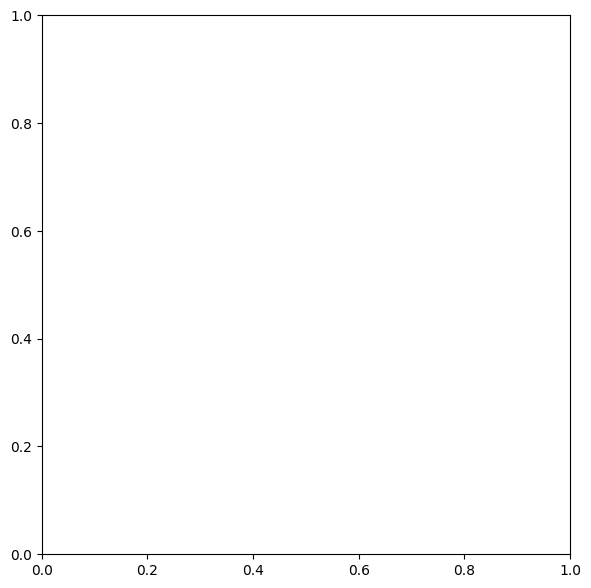

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 80), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 80), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 80), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses on GiMeFive') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 80), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 80), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 80), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies on GiMeFive') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 60), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_gimefive.csv', index=False) # change this CSV